In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [2]:
import pickle
cx_df = pickle.load( open( "cx_df_2.p", "rb" ) )
cx_df.shape

(220171, 28)

In [3]:
# set index to crash_id
cx_df = cx_df.set_index('crash_id')

In [4]:
cx_df.dtypes

crash_fatal_fl                       int64
day_of_week                          int64
datetime                    datetime64[ns]
wthr_cond_id                      category
light_cond_id                     category
crash_speed_limit                    int64
active_school_zone_fl                int64
rr_relat_fl                          int64
crash_date                  datetime64[ns]
crash_time                          object
cnty_id                           category
city_id                           category
surf_cond_id                      category
rpt_rdwy_sys_id                   category
intrsct_relat_id                  category
road_constr_zone_wrkr_fl             int64
road_constr_zone_fl                  int64
road_part_adj_id                  category
road_cls_id                       category
phys_featr_1_id                   category
phys_featr_2_id                   category
onsys_fl                             int64
rural_fl                             int64
holiday    

In [5]:
# create features
features = cx_df.drop(['crash_fatal_fl','crash_date', 'crash_time','datetime'], axis = 1)

In [6]:
features = pd.get_dummies(features, drop_first=False)

In [7]:
# set X and y
X = features
y = cx_df['crash_fatal_fl']

In [8]:
X.head()

,day_of_week,crash_speed_limit,active_school_zone_fl,rr_relat_fl,road_constr_zone_wrkr_fl,road_constr_zone_fl,onsys_fl,rural_fl,holiday,comut_hrs,...,phys_featr_2_id_12.0,phys_featr_2_id_14.0,phys_featr_2_id_15.0,phys_featr_2_id_17.0,phys_featr_2_id_20.0,phys_featr_2_id_21.0,phys_featr_2_id_32.0,phys_featr_2_id_33.0,phys_featr_2_id_98.0,phys_featr_2_id_99.0
crash_id,,,,,,,,,,,,,,,,,,,,,
16175718,1,45,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
16175732,1,50,0,0,0,0,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
16175748,1,40,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16175763,1,50,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16175813,2,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
# baseline
#check y for weird values
y.value_counts()
#chance of an accident being fatal in the last 10 years is .5%

0    218957
1      1214
Name: crash_fatal_fl, dtype: int64

# create confusion matrix to review Type I and II errors.
df_confusion = pd.crosstab(y_train, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

In [10]:
# Confusion Matrix shows an extreme Data imbalance and a significant Type I error rate.

#https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

from sklearn.utils import resample

# Separate input features and target
X = features
y = cx_df['crash_fatal_fl']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=789)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fatal = X[X.crash_fatal_fl==0]
fatal = X[X.crash_fatal_fl==1]

# upsample minority
fatal_upsampled = resample(fatal,
                          replace=True, # sample with replacement
                          n_samples=len(not_fatal), # match number in majority class
                          random_state=789) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fatal, fatal_upsampled])

# check new class counts
upsampled.crash_fatal_fl.value_counts()

1    146694
0    146694
Name: crash_fatal_fl, dtype: int64

In [11]:
y_train = upsampled.crash_fatal_fl
X_train = upsampled.drop('crash_fatal_fl', axis=1)

In [12]:
y_test.shape

(72657,)

In [13]:
up_lr = LogisticRegression(solver='lbfgs', max_iter=5000).fit(X_train, y_train)
up_pred = up_lr.predict(X_test)

In [14]:
accuracy_score(y_test, up_pred)

0.7205637447183341

In [15]:
#harmony score
f1_score(y_test, up_pred)

0.02478505211585571

In [16]:
up_lr.intercept_

array([-1.78036438])

In [17]:
recall_score(y_test, up_pred)

0.6548223350253807

In [18]:
up_y_pred = up_lr.predict(X_train)
# up_df_confusion = pd.crosstab(y_train, up_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
# up_df_confusion

In [19]:
up_y_pred = up_lr.predict(X_test)

In [20]:
up_lr.classes_

array([0, 1])

In [21]:
up_cm_test= confusion_matrix(y_test, up_y_pred)
pd.DataFrame(up_cm_test, columns= ['Pred Non-fatal', 'Pred Fatal'], index=['Actual Non-Fatal', 'Actual Fatal'] )

,Pred Non-fatal,Pred Fatal
Actual Non-Fatal,52096,20167
Actual Fatal,136,258


In [22]:
import pickle
#export the LR Model to be used in Analysis
pickle.dump(up_lr, open( "up_lr_2.p", "wb" ) )

    - a k-nearest neighbors model
    - a decision tree
    - a set of bagged decision trees
    - a random forest
    - an Adaboost model
    - a support vector classifier

In [23]:
#from Lab week 6
def train_eval_model(model):
    model_name= model.__str__().split('(')[0]
    model.fit(X_train, y_train)
    print(model.score(X_train, y_train))
    print(model.score(X_test, y_test))
    print(model.score(X_train, y_train) - model.score(X_test, y_test))

    model_preds = model.predict(X_test)
    model_preds_train = model.predict(X_train)
    print(f1_score(y_train, model_preds_train, average=None)) 
    print(f1_score(y_test, model_preds, average=None))
    return model

In [ ]:
knn = train_eval_model(KNeighborsClassifier(n_jobs=-1))

In [ ]:
# crosstab cm function from: https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
KNeighborsClassifier_preds = knn.predict(X_test)
knn_confusion = pd.crosstab(y_test, KNeighborsClassifier_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
knn_confusion

In [ ]:
dt = train_eval_model(DecisionTreeClassifier())

In [ ]:
DecisionsTreeClassifier_preds = dt.predict(X_test)
dt_confusion = pd.crosstab(y_test, DecisionsTreeClassifier_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
dt_confusion

In [ ]:
rf = train_eval_model(RandomForestClassifier())

In [ ]:
RandomForestClassifier_preds = rf.predict(X_test)
rf_confusion = pd.crosstab(y_test, RandomForestClassifier_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rf_confusion

In [ ]:
bag = train_eval_model(BaggingClassifier())

In [ ]:
BaggingClassifier_preds = bag.predict(X_test)
rf_confusion = pd.crosstab(y_test, BaggingClassifier_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rf_confusion

In [25]:
adb = train_eval_model(AdaBoostClassifier())

0.7108641116882762
0.7188570956686898
-0.007992983980413593
[0.71394995 0.70771097]
[0.83576546 0.02435879]


In [26]:
AdaBoostClassifier_preds = adb.predict(X_test)
adb_confusion = pd.crosstab(y_test, AdaBoostClassifier_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
adb_confusion

Predicted,0,1,All
Actual,,,
0,51975,20288,72263
1,139,255,394
All,52114,20543,72657


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, AdaBoostClassifier_preds))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     72263
           1       0.01      0.65      0.02       394

    accuracy                           0.72     72657
   macro avg       0.50      0.68      0.43     72657
weighted avg       0.99      0.72      0.83     72657



In [28]:
adb_feature = pd.DataFrame(adb.feature_importances_, index=X_train.columns)

In [30]:
adb_feature.loc[adb_feature[0] > .01].sort_values([0])

,0
city_id_246,0.02
city_id_538,0.02
city_id_72,0.02
surf_cond_id_10,0.02
rpt_rdwy_sys_id_11,0.02
rpt_rdwy_sys_id_12,0.02
rpt_rdwy_sys_id_15,0.02
rpt_rdwy_sys_id_3,0.02
rpt_rdwy_sys_id_5,0.02
rpt_rdwy_sys_id_6,0.02


In [ ]:
svc = train_eval_model(SVC())

In [ ]:
SVC_preds = svc.predict(X_test)
svc_confusion = pd.crosstab(y_test, SVC_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
svc_confusion

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
ada_params = {'learning_rate':[1],
    'n_estimators':[200,100,150],
              'algorithm': ['SAMME.R', 'SAMME'],
    'random_state':[789]
}

In [33]:
ada_gridsearch = GridSearchCV(AdaBoostClassifier(), 
                              ada_params, 
                              cv=3, 
                              verbose=4,
                             n_jobs=-1)

In [34]:
ada_gridsearch.fit(X_train, y_train);

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  18 | elapsed:  3.5min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  5.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.9min finished


In [35]:
ada_gridsearch.best_score_

0.7181684322467177

In [36]:
ada_gridsearch.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=200, random_state=789)

In [37]:
ada_gs_preds = ada_gridsearch.predict(X_test)

In [38]:
ada_gs_confusion = pd.crosstab(y_test, ada_gs_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
ada_gs_confusion

Predicted,0,1,All
Actual,,,
0,52492,19771,72263
1,139,255,394
All,52631,20026,72657


In [44]:
ada_gridsearch.n_splits_

3

In [59]:
ada_gs_proba_test = ada_gridsearch.predict_proba(X_test)[:,1]

In [60]:
ada_gs_proba_train = ada_gridsearch.predict_proba(X_train)[:,1]


In [61]:
ada_gs_proba_train.shape

(293388,)

https://stats.stackexchange.com/questions/110981/why-is-adaboost-predicting-probabilities-with-so-little-standard-deviation
http://fastml.com/classifier-calibration-with-platts-scaling-and-isotonic-regression/

In [62]:
from sklearn.isotonic import IsotonicRegression as IR

ir = IR( out_of_bounds = 'clip' )
ir.fit( ada_gs_proba_train, y_train )
p_calibrated = ir.transform( ada_gs_proba_test )   # or ir.fit( p_test ), that's the same thing

Text(0.5, 1.0, 'Estimated Population for Travis and Williamson Counties')

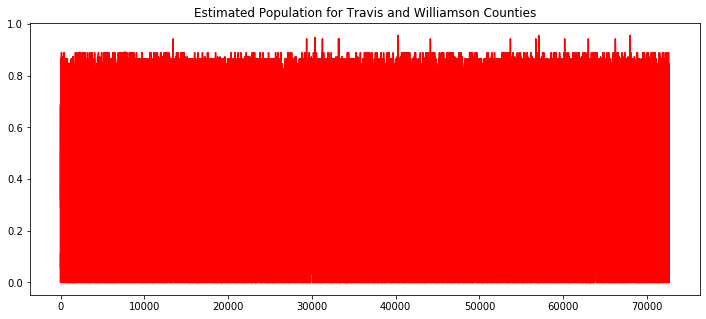

In [70]:
plt.figure(figsize=(12,5))
plt.plot(p_calibrated, color='r')
plt.title("Estimated Population for Travis and Williamson Counties")


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ada_gs_preds))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     72263
           1       0.01      0.65      0.02       394

    accuracy                           0.73     72657
   macro avg       0.51      0.69      0.43     72657
weighted avg       0.99      0.73      0.84     72657



lr_params = {
    '':[],
    '':['',''],
    '':[''],
    '':[],
}

lr_gridsearch = GridSearchCV(LogisticRegression(),
                              lr_params, 
                              cv=5, 
                              verbose=4,
                             n_jobs=-1)

In [ ]:
knn_params = {
    'n_neighbors':[3,7],
    'weights':['uniform','distance'],
    'algorithm':['auto'],
    'p':[1,2],
}

n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,

In [ ]:
knn_gridsearch = GridSearchCV(KNeighborsClassifier(),
                              knn_params, 
                              cv=5, 
                              verbose=2,
                             n_jobs=-1)

In [ ]:
knn_gridsearch.fit(X_train, y_train);

In [ ]:
print(knn_gridsearch.best_score_)
knn_gridsearch.best_estimator_

In [ ]:
knn_gs_preds = knn_gridsearch.predict(X_test)iKi

In [ ]:
knn_gs_confusion = pd.crosstab(y_test, knn_gs_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
knn_gs_confusion